# Example Notebook: Halloween Classifier using Random Forest


## Introduction

This notebook shows an example of how you can train a Random Forest Classifier to predict different types of monsters based on features from a dataset. We’ll walk through the complete machine learning workflow, including data loading, preprocessing, model training, evaluation, and testing.

In this project, we use data from two sources: `Crimes_Dataset.csv`, which contains details on various fictional crimes, and `Suspects_Dataset.csv`, which provides information on potential suspects. The goal is to combine these datasets, preprocess the data, and build a model that can predict the type of "monster" involved in each crime.

### Key Steps

- **Data Loading**: Load and inspect the datasets to understand their structure and identify key features.
- **Data Preprocessing**: Clean the data, handle missing values, and encode categorical features.
- **Data Exploration**: Explore features and patterns in the data to guide our analysis and better understand the relationships between variables.
- **Model Training**: Build and train a Random Forest classifier on the preprocessed data.
- **Model Evaluation**: Assess model performance using metrics like accuracy, precision, recall, and F1 score.
- **Model Saving and Inference**: Save the trained model and use it to make predictions on new data.
- **Final Testing**: Evaluate the model on a separate test set to assess real-world performance. _Note: This final testing was conducted by the Data Bootcamp committee and is not expected as part of the challenge itself._

By the end of this notebook, we will have a trained Random Forest model that can classify monster types based on the features provided, along with insights into its performance and areas for improvement.


In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

## Data Preprocessing

### Data Cleaning and Feature Selection

In this section, we prepare the data for model training by performing essential cleaning and preprocessing tasks. We start by standardizing text data, handling missing values, and merging the datasets. These steps are critical to ensure that the model receives consistent and meaningful input.

- **Lowercasing**: Converting all string data to lowercase to maintain consistency across text features.
- **Handling Missing Values**: Dropping or filling in missing values where needed, as these could otherwise lead to errors during model training.
- **Merging Datasets**: We combine the `Crimes_Dataset` and `Suspects_Dataset` based on unique identifiers. This merged dataset will contain all relevant information for training the model.

### Encoding Categorical Variables and Preparing for the Model Pipeline

Since machine learning models require numerical inputs, categorical features (e.g., crime type, region, weapon type) must be converted into numerical format. This conversion is likely handled within the model pipeline, which may use encoding methods such as `OneHotEncoder`. Encoding ensures that categorical features are represented in a way that the model can process effectively.

After these preprocessing steps, we’ll have a cleaned, structured dataset ready for feature selection and model training.


In [2]:
crimes_dataset = pd.read_csv('data/Crimes_Dataset.csv')
crimes_dataset.head(3)

,Index_Crimes,Date,Monster involved,Days of Investigation,Region,Crime Type,Crime Weapon,Time of Day,Evidence Found
0,6316,2020-02-18,Skeleton,77.0,mountain,nightly disturbance,NaN,night,bones
1,4731,2022-09-01,Werewolf,48.0,forest,assault,pistol,night,teeth
2,1750,2022-08-03,Ghost,31.0,castle,nightly disturbance,NaN,night,potions


In [3]:
# Change all the column names to lowercase
crimes_dataset.columns = crimes_dataset.columns.str.lower()

# Change all the string values to lowercase using DataFrame.apply and DataFrame.applymap alternatives
crimes_dataset = crimes_dataset.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)

# Display the first 3 rows of the updated dataset
crimes_dataset.head(3)


,index_crimes,date,monster involved,days of investigation,region,crime type,crime weapon,time of day,evidence found
0,6316,2020-02-18,skeleton,77.0,mountain,nightly disturbance,NaN,night,bones
1,4731,2022-09-01,werewolf,48.0,forest,assault,pistol,night,teeth
2,1750,2022-08-03,ghost,31.0,castle,nightly disturbance,NaN,night,potions


In [4]:
suspects_dataset = pd.read_csv('data/Suspects_Dataset.csv')

# Change all the column names to lowercase
suspects_dataset.columns = suspects_dataset.columns.str.lower()
# change all the column values to lowercase (if not numerical data)
suspects_dataset = suspects_dataset.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
suspects_dataset.head(3)

,index_monster,monster,criminal record,age,gender,height in cm,speed level,strength level,allergy,favorite food
0,2101,witch,no,526.0,f,197.0,16.0,1.0,hazelnut,brain
1,9299,zombie,yes,46.0,m,184.0,20.0,7.0,cat hair,humans
2,6824,vampire,no,442.0,m,192.0,21.0,7.0,sunlight,pesto pasta


## A Few Insights into the Dataset Based on the Storyline

In this section, we perform data exploration to uncover meaningful patterns related to the storyline. Data exploration helps us to understand the characteristics and distribution of our data, guiding our modeling decisions and giving us insight into possible outcomes.


In [5]:
# information about the values in Speed Level column (min, max, mean, etc.)
suspects_dataset['speed level'].describe()


count    9999.000000
mean       36.465047
std        23.995856
min         1.000000
25%        17.000000
50%        30.000000
75%        51.000000
max       100.000000
Name: speed level, dtype: float64

In [6]:
# How many times does the value "village" appear in the "Region" column of crimes_dataset?
village_count = crimes_dataset['region'].str.contains('village').sum()
print(village_count)

2301


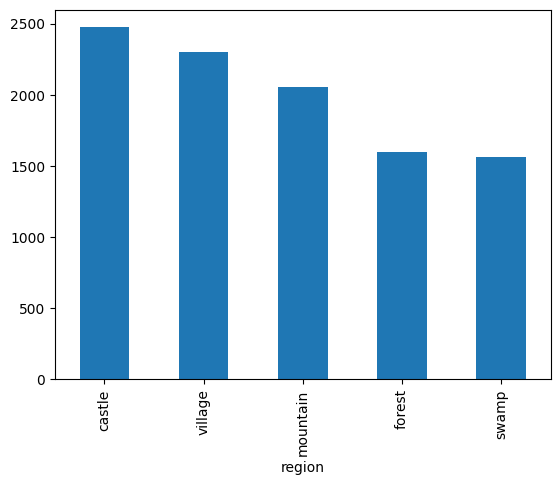

In [7]:
# show the distribution of the values in the "Region" column

crimes_dataset['region'].value_counts().plot(kind='bar')
plt.show()


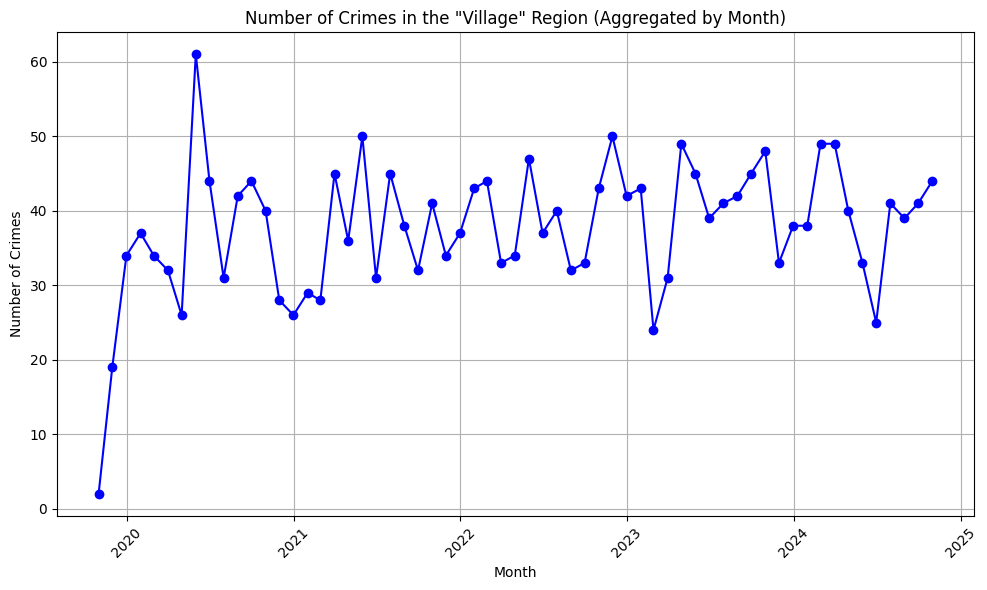

In [8]:
crimes_dataset_new = crimes_dataset.copy()

# Convert the 'Date' column to datetime in case it's not already
crimes_dataset_new['date'] = pd.to_datetime(crimes_dataset_new['date'])

# Filter the dataset for crimes that happened in the "village" region
village_crimes = crimes_dataset_new[crimes_dataset_new['region'] == 'village']

# Aggregate the number of crimes per month
village_crimes_monthly = village_crimes.resample('ME', on='date').size()

# Plot the aggregated number of crimes per month
plt.figure(figsize=(10, 6))
plt.plot(village_crimes_monthly.index, village_crimes_monthly.values, marker='o', linestyle='-', color='b')
plt.title('Number of Crimes in the "Village" Region (Aggregated by Month)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
# Explore insights about crimes in the village
# Group by monster involved, crime type, and time of day to get more insights

# Filter village crimes again in case the dataset was updated
village_crimes = crimes_dataset_new[crimes_dataset_new['region'] == 'village']

# Get the most common monsters involved in village crimes
monsters_in_village = village_crimes['monster involved'].value_counts()

# Get the most common types of crimes in the village
crime_types_in_village = village_crimes['crime type'].value_counts()

# Get the most common times of day crimes occur in the village
time_of_day_in_village = village_crimes['time of day'].value_counts()

monsters_in_village, crime_types_in_village, time_of_day_in_village


(monster involved
 witch       841
 ghost       736
 vampire     315
 zombie      230
 werewolf    179
 Name: count, dtype: int64,
 crime type
 arson                  583
 nightly disturbance    412
 kidnapping             402
 assault                361
 vandalism              337
 theft                  148
 murder                  58
 Name: count, dtype: int64,
 time of day
 night    1161
 dusk      514
 dawn      328
 day       298
 Name: count, dtype: int64)

<Axes: xlabel='monster involved'>

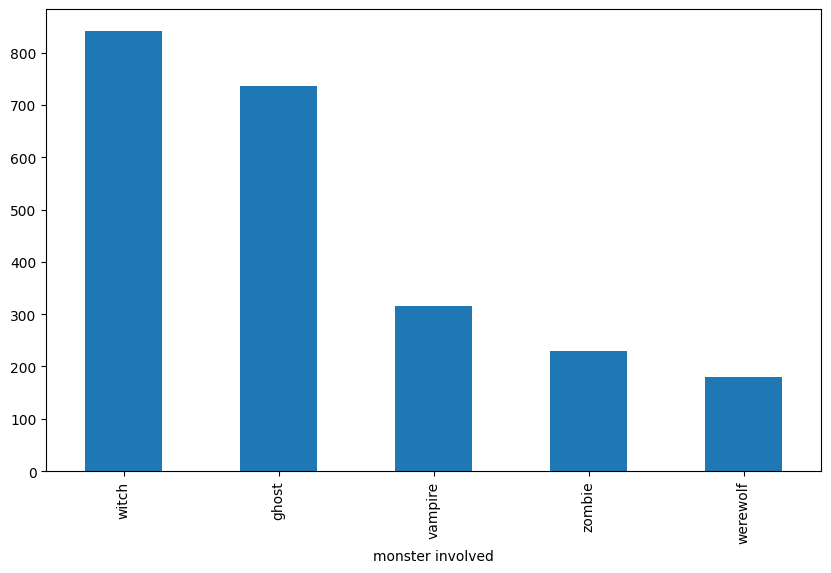

In [10]:
# generate a bar plot for 'monsters_in_village'
plt.figure(figsize=(10, 6))

monsters_in_village.plot(kind='bar')

<Axes: xlabel='time of day'>

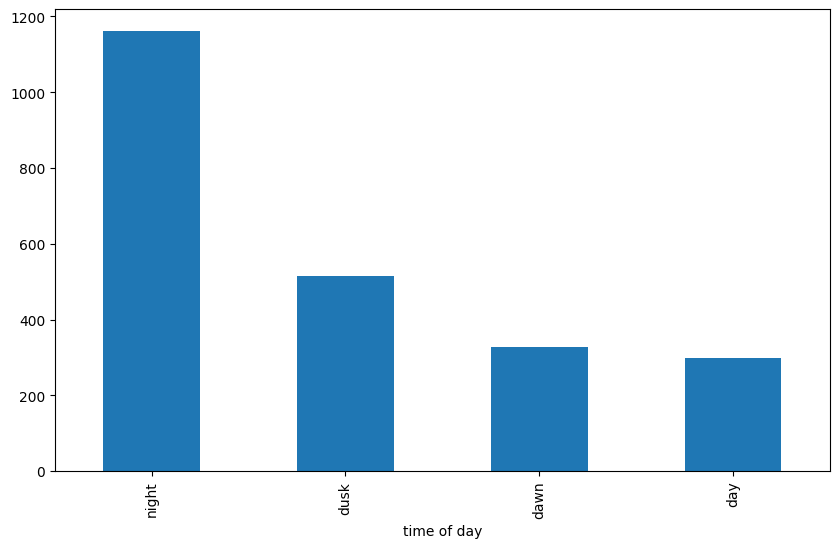

In [11]:
# generate a bar plot for 'time_of_day_in_village
plt.figure(figsize=(10, 6))

time_of_day_in_village.plot(kind='bar')

In [12]:
# Filter village crimes for kidnappings that occurred during the day
village_day_kidnappings = village_crimes[(village_crimes['crime type'] == 'kidnapping') & 
                                         (village_crimes['time of day'] == 'day')]

len(village_day_kidnappings)


94

In [13]:
village_day_kidnappings['monster involved'].value_counts()

monster involved
witch     71
zombie    23
Name: count, dtype: int64

**Summary of Data Exploration**

Data exploration helps us uncover patterns that guide our analysis and align with our storyline. For instance, we can see that crimes in the village occur fairly regular and there are only a few months in the data where there are clearly more/less crimes. By examining features like region, time of day, and crime type, we noticed that crimes in the "village" occur frequently at night, with witches and ghosts as the main suspects. Kidnappings during the day, although less common, are linked primarily to witches and zombies. These insights narrow our focus to specific suspects and conditions, showing how careful exploration can inform and refine our approach to building effective models.

**Note**: By focusing the combination of feature "village", "kidnapping", and "time of day" we limit our exploration to a small group of suspects. Starting with a different selection of features might lead us to a different group of suspects. Therefore, spending enough time with data exploration is always recommended in order to understand our data before building models.


## Model Training

Before training the classification model, we can merge the two data sets by their respective indexes. We then set aside a part of the data in order to assess the performance of the classifier.


In [14]:
# Merge the crimes and suspects datasets on matching index
df = pd.merge(crimes_dataset, suspects_dataset, left_on='index_crimes', right_on='index_monster')
df.head(3)



,index_crimes,date,monster involved,days of investigation,region,crime type,crime weapon,time of day,evidence found,index_monster,monster,criminal record,age,gender,height in cm,speed level,strength level,allergy,favorite food
0,6316,2020-02-18,skeleton,77.0,mountain,nightly disturbance,NaN,night,bones,6316,skeleton,yes,1.0,f,152.0,26.0,8.0,silver,lasagna
1,4731,2022-09-01,werewolf,48.0,forest,assault,pistol,night,teeth,4731,werewolf,no,53.0,m,171.0,87.0,7.0,silver,pesto pasta
2,1750,2022-08-03,ghost,31.0,castle,nightly disturbance,NaN,night,potions,1750,ghost,no,1634.0,m,185.0,59.0,2.0,sunlight,humans


In [15]:
# delete column "monster" in df
df.drop('monster', axis=1, inplace=True)

# # renema column "Monster involved" to "Monster"
# df.rename(columns={'monster involved': 'Monster'}, inplace=True)

# rename all columns to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(3)

,index_crimes,date,monster_involved,days_of_investigation,region,crime_type,crime_weapon,time_of_day,evidence_found,index_monster,criminal_record,age,gender,height_in_cm,speed_level,strength_level,allergy,favorite_food
0,6316,2020-02-18,skeleton,77.0,mountain,nightly disturbance,NaN,night,bones,6316,yes,1.0,f,152.0,26.0,8.0,silver,lasagna
1,4731,2022-09-01,werewolf,48.0,forest,assault,pistol,night,teeth,4731,no,53.0,m,171.0,87.0,7.0,silver,pesto pasta
2,1750,2022-08-03,ghost,31.0,castle,nightly disturbance,NaN,night,potions,1750,no,1634.0,m,185.0,59.0,2.0,sunlight,humans


In [16]:

# Separate the features and target
X = df.drop(columns=['monster_involved', 'index_crimes', 'index_monster'])
y = df['monster_involved']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

# Preprocessing for numerical data (fill missing values)
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data (one-hot encode)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that preprocesses the data and then applies the classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

### Model Evaluation


In [17]:
# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", report)

Accuracy: 0.9735
Precision: 0.9735203540078057
Recall: 0.9735
F1 Score: 0.973488168264482

Classification Report:
               precision    recall  f1-score   support

       ghost       0.97      0.98      0.97       338
    skeleton       0.95      0.95      0.95       317
     vampire       0.97      0.98      0.97       328
    werewolf       0.98      0.98      0.98       364
       witch       0.99      0.97      0.98       320
      zombie       0.98      0.99      0.99       333

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [18]:
# Retrieve feature importances from the trained RandomForest model
importances = model_pipeline.named_steps['classifier'].feature_importances_

# Get the feature names from the preprocessor (after one-hot encoding)
categorical_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(categorical_feature_names)

# Create a DataFrame to view feature importances
feature_importances = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Show the top feature importances
feature_importances.head(10)


,feature,importance
1,age,0.133022
3,speed_level,0.099891
1835,evidence_found_bones,0.039877
1813,region_castle,0.032708
4,strength_level,0.032211
1846,allergy_hazelnut,0.032188
1818,crime_type_arson,0.027759
1819,crime_type_assault,0.027194
1848,allergy_silver,0.026556
1849,allergy_sunlight,0.023648


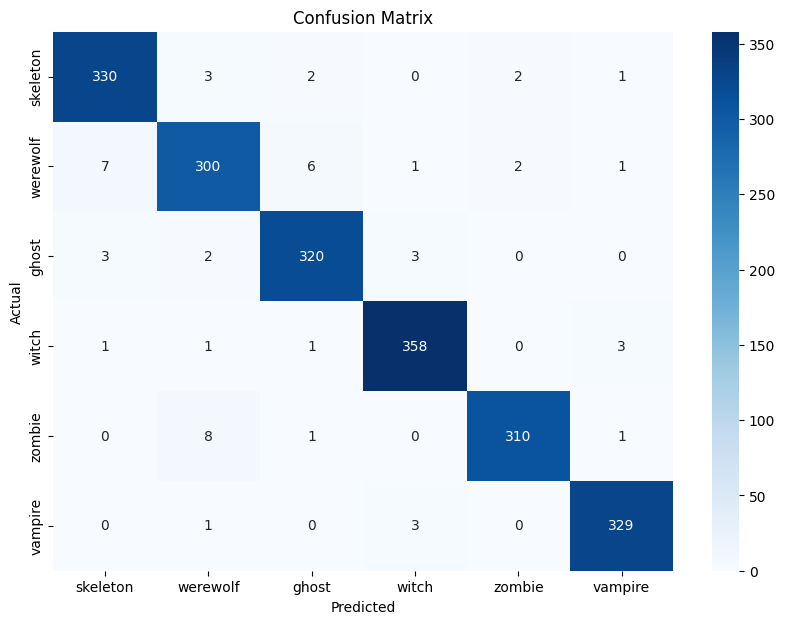

In [19]:
# Visualise training results using a Confusion Matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


As we can see, the model only makes a few mistakes. Once we are happy with the results, we can save the model to be then able to test it against other data not seen during the training.


#### Saving the Model


In [20]:
# Save the trained model to a file
joblib.dump(model_pipeline, 'trained_model_pipeline.pkl')


['trained_model_pipeline.pkl']

## Inference: Predicting the Monster for a crime


In [21]:
# Load the saved model from the file
loaded_model = joblib.load('trained_model_pipeline.pkl')


In [22]:
# Target from Crimes:
""" 
2025-10-30,Witch,67,village,kidnapping,knive,day,bones
"""

# Target from Suspects:
""" 
Witch,Yes,443,M,172,26,1,pumpkin,lasange
"""

' \nWitch,Yes,443,M,172,26,1,pumpkin,lasange\n'

In [23]:
"""
Target variable is Monster involved: Witch

Date: 2025-10-30
Region: village
Crime Type: kidnapping
Time of Day: Day
Evidence Found: Bones
Weapon Used: Knive
"""

'\nTarget variable is Monster involved: Witch\n\nDate: 2025-10-30\nRegion: village\nCrime Type: kidnapping\nTime of Day: Day\nEvidence Found: Bones\nWeapon Used: Knive\n'

In [24]:

# Create a dictionary for the input features based on the story
story_input = {
    'region': ['village'],  # Region from the story
    'time_of_day': ['day'],  # Time of day from the story
    'speed_level': [None],  # Placeholder for missing feature
    'date': '2025-10-30',  # Placeholder for missing feature
    'crime_type': ['kidnapping'],  # Placeholder for missing feature
    'height_in_cm': [None],  # Placeholder for missing feature
    'gender': [None],  # Placeholder for missing feature
    'crime_weapon': ['knive'],  # Crime weapon from the story
    'allergy': [None],  # Placeholder for missing feature
    'strength_level': [None],  # Placeholder for missing feature
    'criminal_record': [None],  # Placeholder for missing feature
    'days_of_investigation': [None],  # Placeholder for missing feature
    'age': [None],  # Placeholder for missing feature
    'favorite_food': [None],  # Placeholder for missing feature
    'evidence_found': ['bones']  # Evidence from the story
}

# Convert the dictionary into a DataFrame
story_df = pd.DataFrame(story_input)

# Use the loaded model for inference without retraining
predicted_monster = loaded_model.predict(story_df)

# Output the predicted monster
print(predicted_monster[0])


witch


## Performance Assessment on Test Set (conducted by Data Bootcamp committee)

Here, we include additional testing conducted by the Data Bootcamp committee after the code was submitted. This step uses a separate test set to assess how well the model generalizes beyond the training data. This assessment is not part of the required challenge but provides extra insight how well the classification model generalizes to unseen data.


In [25]:
# Load the saved model pipeline (if not already loaded)
loaded_model = joblib.load('trained_model_pipeline.pkl')

In [26]:
# some data preprocessing so that the column names and feature names fit between the training and test data

# Load the test data
test_data = pd.read_csv('data/test.csv')
# Change all the column names to lowercase
test_data.columns = test_data .columns.str.lower()

# rename all columns to lowercase and replace spaces with underscores
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# Change all the string values to lowercase using DataFrame.apply and DataFrame.applymap alternatives
test_data  = test_data.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
test_data.head(3)

,date,monster_involved,days_of_investigation,region,crime_type,crime_weapon,time_of_day,evidence_found,criminal_record,age,gender,height_in_cm,speed_level,strength_level,allergy,favorite_food,id
0,2023-05-23,zombie,92,swamp,assault,NaN,night,potions,no,97,f,162,14,1,sunlight,humans,2211
1,2023-06-02,ghost,39,village,vandalism,axe,night,potions,yes,2440,f,170,63,6,pumpkin,pesto pasta,7676
2,2020-01-02,vampire,8,castle,assault,brute force,night,cloak,no,242,m,183,42,6,garlic,brain,3465


In [27]:

# Select only the relevant feature columns (ensure these match those used in the model pipeline)
# X_test = test_data[['region', 'time_of_day', 'speed_level', 'date', 'crime_type', 'height_in_cm', 'gender',
#                     'crime_weapon', 'allergy', 'strength_level', 'criminal_record', 'days_of_investigation',
#                     'age', 'favorite_food', 'evidence_found']]
# y_test = test_data['monster_involved']  # Target variable


X_test = test_data.drop(columns=['monster_involved', 'id'])
y_test = test_data['monster_involved']

# Predict using the loaded model pipeline
y_pred = loaded_model.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", report)


Accuracy: 0.98
Precision: 0.9810230179028133
Recall: 0.98
F1 Score: 0.979940045617465

Classification Report:
               precision    recall  f1-score   support

       ghost       1.00      1.00      1.00        16
    skeleton       1.00      0.94      0.97        16
     vampire       0.96      1.00      0.98        22
    werewolf       0.94      1.00      0.97        16
       witch       1.00      0.94      0.97        16
      zombie       1.00      1.00      1.00        14

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



Performance of 98% F1-score on unseen data suggests that our classification model is able to generalize well for unseen data and should give us good predictions of the monster involved in crimes.
